In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/DATA_MINING_PROJECT/'
except ImportError as e:
    pass

Mounted at /content/drive/
/content/drive/My Drive/DATA_MINING_PROJECT


## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

## Reading data

In [ ]:
df_holidays = pd.read_csv('Data_Mining-master/holidays_events.csv', header = 0)
df_oil = pd.read_csv('Data_Mining-master/oil.csv', header = 0)
df_stores = pd.read_csv('Data_Mining-master/stores.csv', header = 0)
df_trans = pd.read_csv('Data_Mining-master/transactions.csv', header = 0)
df_train = pd.read_csv('Data_Mining-master/train.csv', header = 0)
df_test = pd.read_csv('Data_Mining-master/test.csv', header = 0)

##Preprocessing

In [ ]:
# Create a list of DataFrames
dataframes = [df_holidays, df_oil, df_trans, df_train, df_test]
# Loop through the list of DataFrames and convert the 'date' column to datetime
for df in dataframes:
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

In [ ]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
df_train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [ ]:
print(df_train.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [ ]:
# Check for missing values
print(df.isnull().sum())

# Impute missing values
df['onpromotion'].fillna(False, inplace=True)

# Check for duplicates
print(df.duplicated().sum())

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
0


In [ ]:
# Combine with oil prices
df_train = pd.merge(df_train, df_oil, on='date', how='left')
df_test = pd.merge(df_test, df_oil, on='date', how='left')

# Combine with holidays/events
df_train = pd.merge(df_train, df_holidays, on='date', how='left')
df_test = pd.merge(df_test, df_holidays, on='date', how='left')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 12 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   dcoilwtico   float64       
 7   type         object        
 8   locale       object        
 9   locale_name  object        
 10  description  object        
 11  transferred  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 279.6+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
 5   dcoilwtico   21384 non-null  float64       
 6   type         1782 non-null   object        
 7   locale       1782 non-null   object        
 8   locale_name  1782 non-null   object        
 9   description  1782 non-null   object        
 10  transferred  1782 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 2.4+ MB


##Weekly aggregation

The parameter freq='W-MON' specifies the frequency of the time series data. When you specify freq='W-MON', pandas will automatically group the data into weekly intervals, starting from Mondays

In [55]:
# Aggregate sales on a weekly basis
weekly_sales = df_train.groupby(['store_nbr', 'family', pd.Grouper(key='date', freq='W-MON')])['sales'].sum().reset_index()
weekly_sales.head()

,store_nbr,family,date,sales
0,1,AUTOMOTIVE,2013-01-07,15.0
1,1,AUTOMOTIVE,2013-01-14,15.0
2,1,AUTOMOTIVE,2013-01-21,12.0
3,1,AUTOMOTIVE,2013-01-28,18.0
4,1,AUTOMOTIVE,2013-02-04,16.0


In [56]:
weekly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431244 entries, 0 to 431243
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   store_nbr  431244 non-null  int64         
 1   family     431244 non-null  object        
 2   date       431244 non-null  datetime64[ns]
 3   sales      431244 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 13.2+ MB


##Useful insights on Weekly basis data
1. Plots the weekly sales trend over time.
2. Visualizes the distribution of weekly sales.
3. Performs seasonal decomposition to identify trend, seasonal, and residual components.

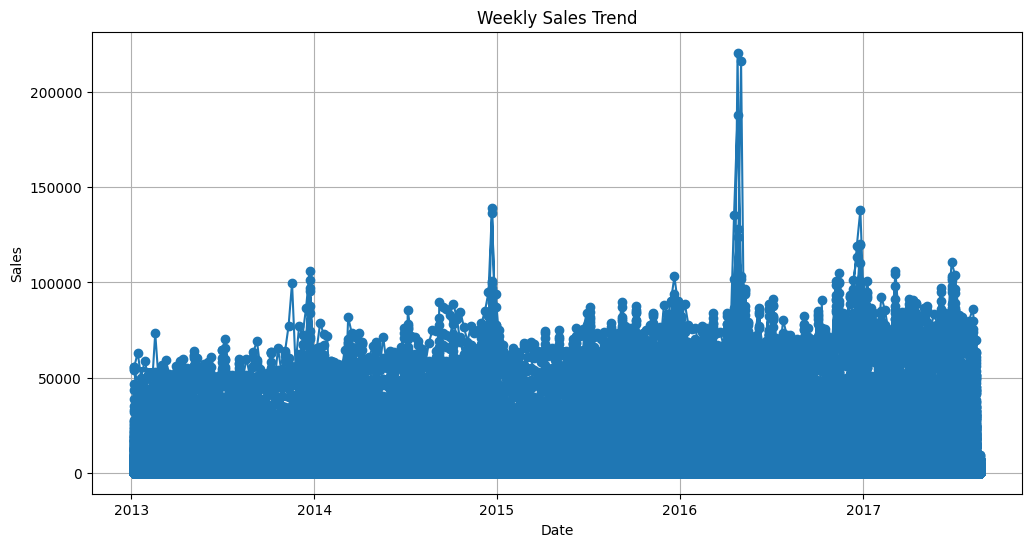

In [ ]:
#1. Plot weekly sales trend
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales['date'], weekly_sales['sales'], marker='o', linestyle='-')
plt.title('Weekly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


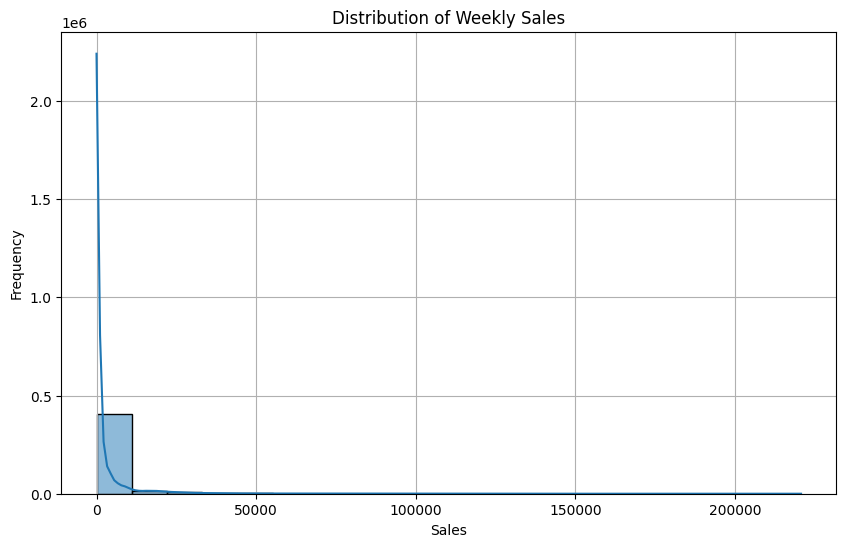

In [ ]:
#2. Plot distribution of weekly sales
plt.figure(figsize=(10, 6))
sns.histplot(weekly_sales['sales'], bins=20, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

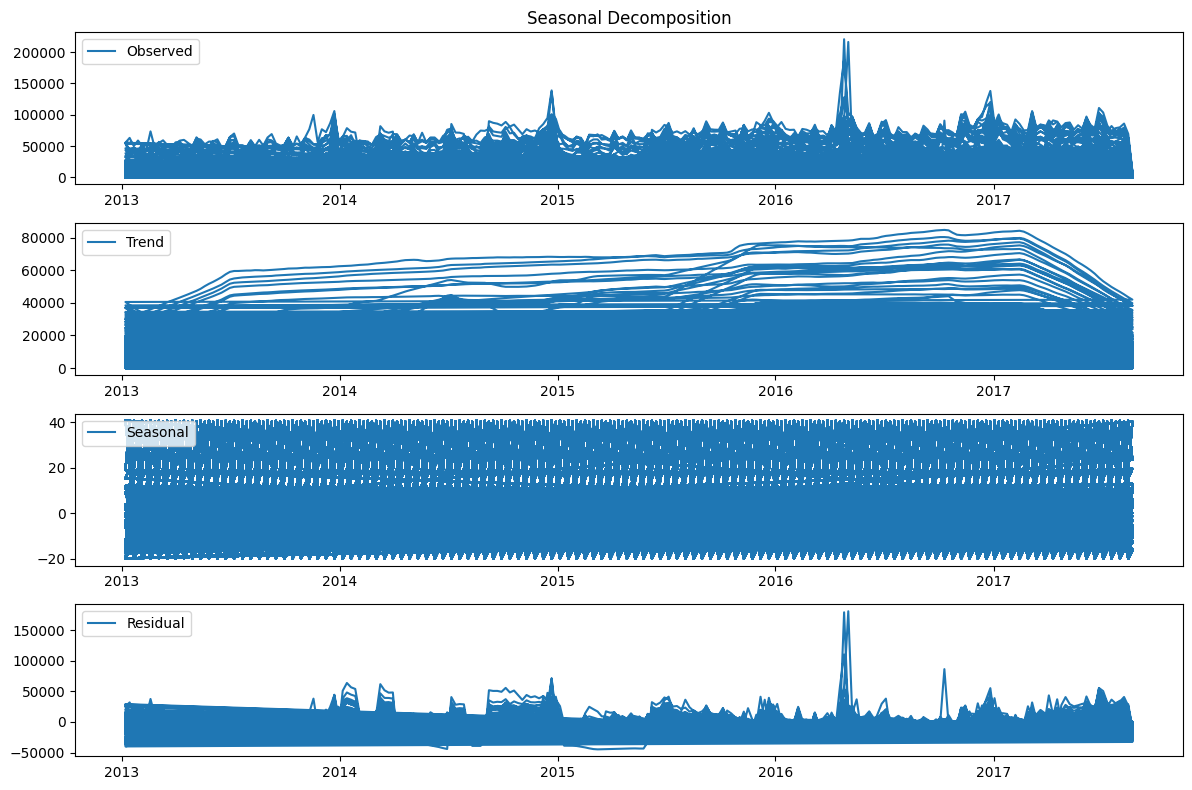

In [ ]:
#3. Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_sales['sales'], model='additive', period=52)

# Plot seasonal decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(weekly_sales['date'], decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.title('Seasonal Decomposition')
plt.subplot(412)
plt.plot(weekly_sales['date'], decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(weekly_sales['date'], decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(weekly_sales['date'], decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#Perform EDA
##Compute the correlation between weekly sales and external factors (oil price, holidays) and plot a correlation heatmap.

In [ ]:
# Merge external factors with weekly sales data
weekly_sales = pd.merge(weekly_sales, df_oil, on='date', how='left')
weekly_sales = pd.merge(weekly_sales, df_holidays, on='date', how='left')

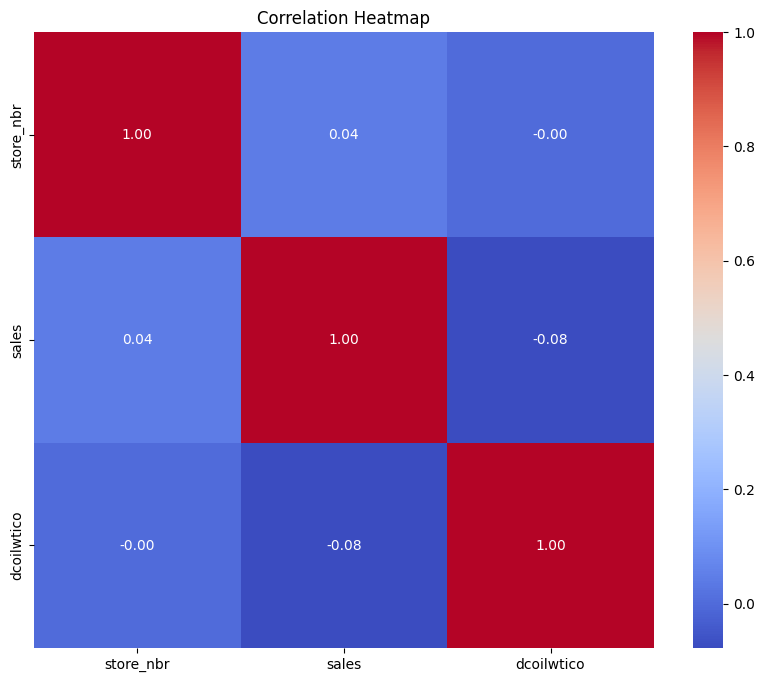

In [ ]:
# Exclude non-numeric columns
numeric_columns = weekly_sales.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

##Visualize the sales distribution by store and product family using boxplots.

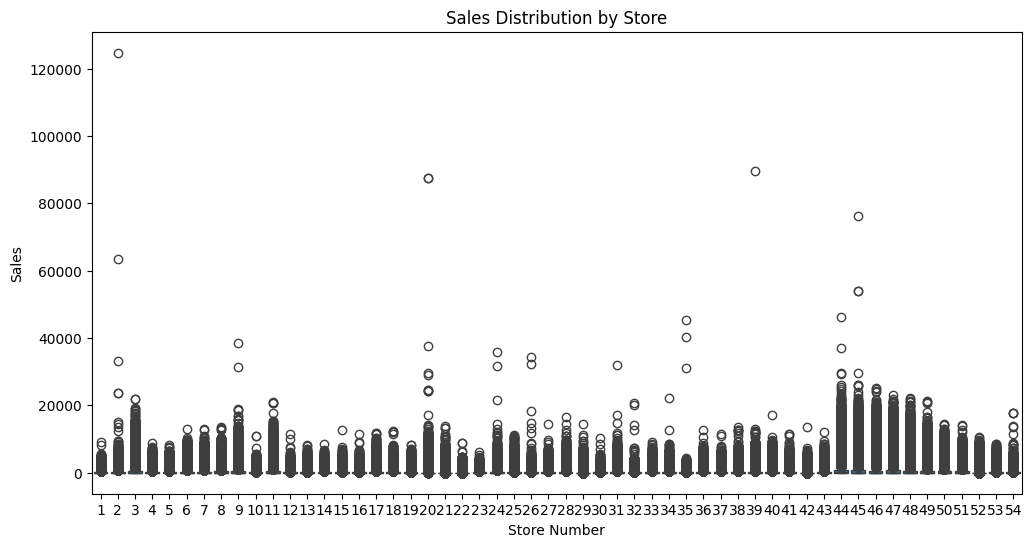

In [ ]:
# Sales distribution by store or product family

# Merge store metadata with train data
df_train = pd.merge(df_train, df_stores, on='store_nbr', how='left')

# Plot sales distribution by store
plt.figure(figsize=(12, 6))
sns.boxplot(x='store_nbr', y='sales', data=df_train)
plt.title('Sales Distribution by Store')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.show()



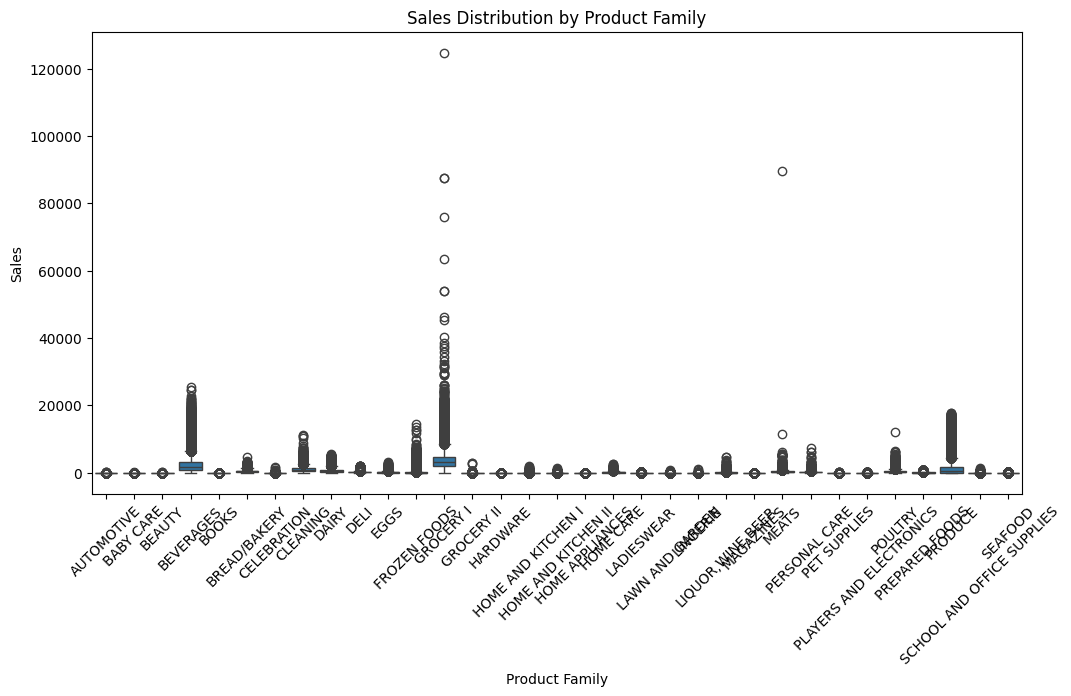

In [ ]:
# Plot sales distribution by product family
plt.figure(figsize=(12, 6))
sns.boxplot(x='family', y='sales', data=df_train)
plt.title('Sales Distribution by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

##Investigate the impact of promotions on sales by comparing sales with and without promotions.

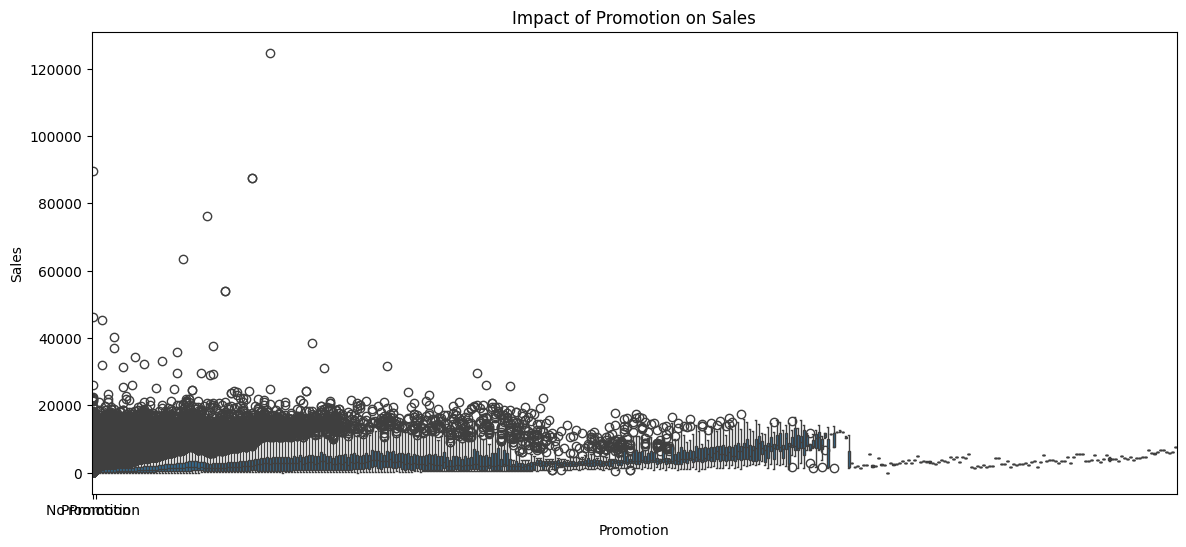

In [ ]:
# Impact of promotions on sales

# Plot sales with and without promotion
plt.figure(figsize=(14, 6))
sns.boxplot(x='onpromotion', y='sales', data=df_train)
plt.title('Impact of Promotion on Sales')
plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.xticks([0, 1], ['No Promotion', 'Promotion'])
plt.show()

##Explore the seasonality patterns for specific stores or product families by plotting their sales trends over time.

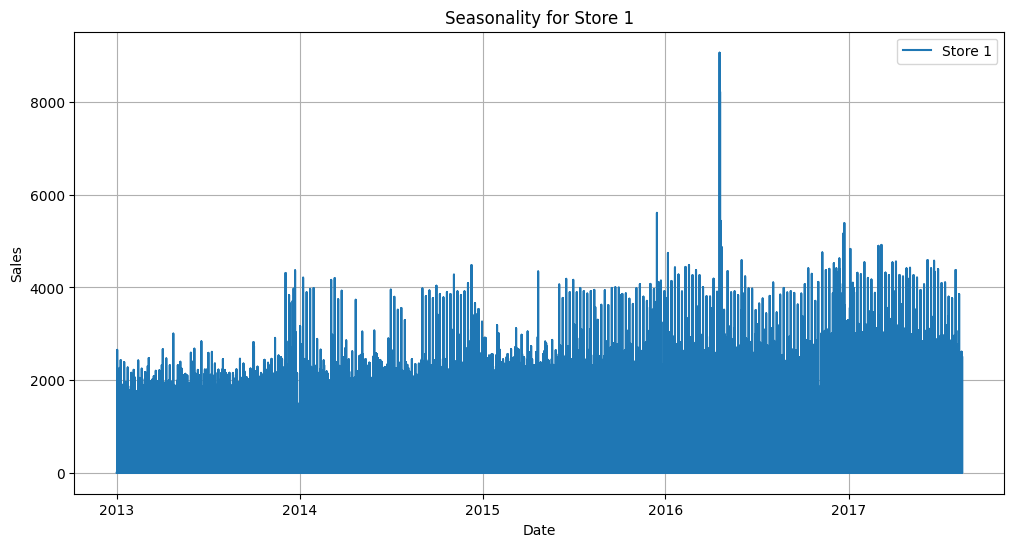

In [ ]:
# Seasonality patterns for specific stores or product families

# Choose specific store or product family
store_nbr = 1
product_family = 'GROCERY I'

# Filter data for the chosen store or product family
store_data = df_train[df_train['store_nbr'] == store_nbr]
family_data = df_train[df_train['family'] == product_family]

# Plot seasonality for the chosen store or product family
plt.figure(figsize=(12, 6))
plt.plot(store_data['date'], store_data['sales'], label=f'Store {store_nbr}')
plt.title(f'Seasonality for Store {store_nbr}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()



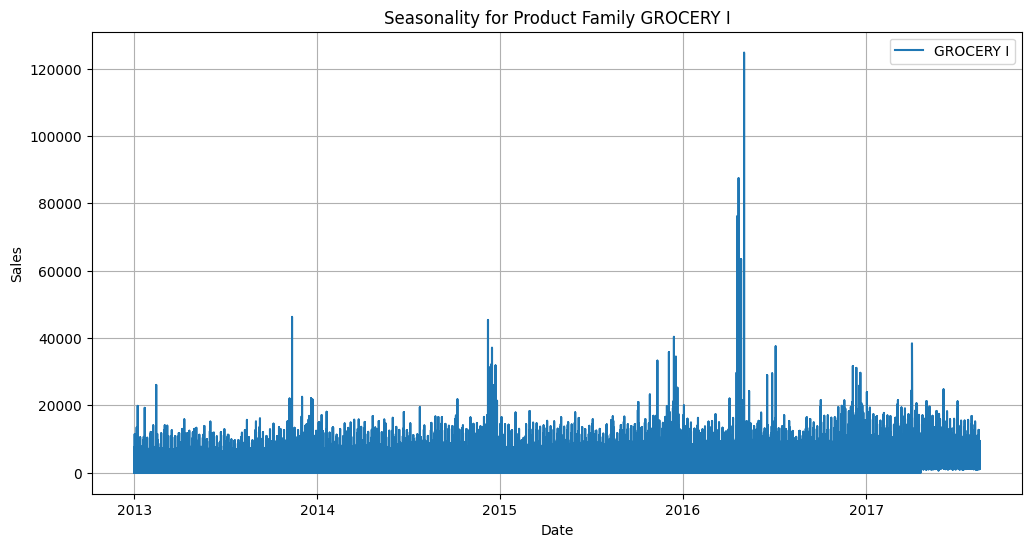

In [ ]:
# Filter data for the chosen product family
plt.figure(figsize=(12, 6))
plt.plot(family_data['date'], family_data['sales'], label=product_family)
plt.title(f'Seasonality for Product Family {product_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

##Weekly sales for a particular store and family

In [ ]:
# Plot weekly sales for a particular store and family
def plot_weekly_sales(store_nbr, family):
    data = weekly_sales[(weekly_sales['store_nbr'] == store_nbr) & (weekly_sales['family'] == family)]
    plt.figure(figsize=(10, 6))
    plt.plot(data['date'], data['sales'], marker='o')
    plt.title(f'Weekly Sales for Store {store_nbr} - {family}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.show()

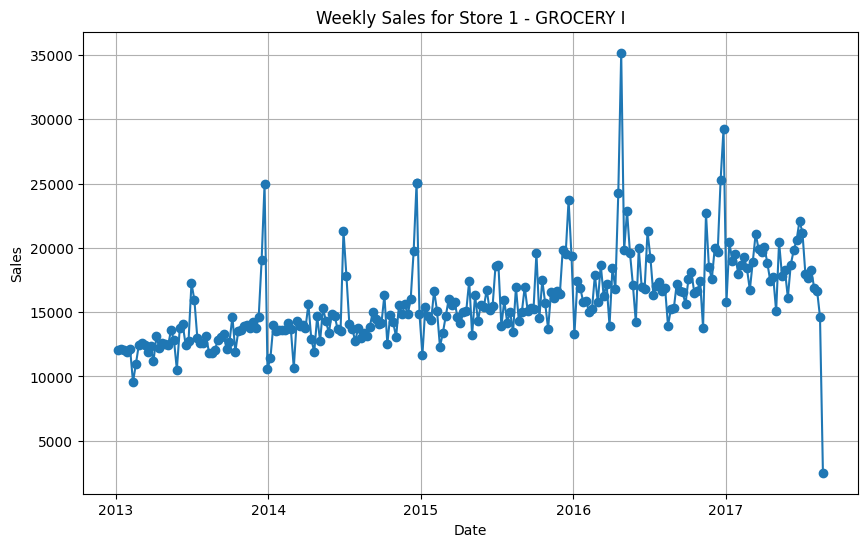

In [ ]:
# Example plot
plot_weekly_sales(1, 'GROCERY I')

##Applying ARIMA Model
Applied the ARIMA modeling for a particular store and family based on weekly sales

In [ ]:
# Define a function to fit ARIMA model
def fit_arima_model(series, order):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    return model_fit


In [ ]:
# Define a function to make predictions with ARIMA model
def arima_forecast(model_fit, steps):
    forecast = model_fit.forecast(steps=steps)
    return forecast

In [51]:
# ARIMA modeling for a particular store and family based on weekly sales
def arima_modeling(store_nbr, family):
    data = weekly_sales[(weekly_sales['store_nbr'] == store_nbr) & (weekly_sales['family'] == family)]
    series = data.set_index('date')['sales']

    # Check for stationarity
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

    # Plot ACF and PACF
    plot_acf(series)
    plt.show()
    plot_pacf(series)
    plt.show()

    # Fit ARIMA model
    order = (1, 1, 1)  # Example order, you can choose based on ACF and PACF plots
    model_fit = fit_arima_model(series, order)

    # Ensure the 'date' column is set as the index with frequency 'W-MON'
    series.index = pd.date_range(start=series.index.min(), periods=len(series), freq='W-MON')

    # Now, when making predictions, provide a forecast horizon with dates
    forecast_horizon = pd.date_range(start=series.index[-1] + pd.Timedelta(days=7), periods=4, freq='W-MON')
    forecast = model_fit.forecast(steps=len(forecast_horizon))
    forecast.index = forecast_horizon
    print('ARIMA Forecast:', forecast)

    # Evaluate model
    train_size = int(len(series) * 0.8)
    train, test = series[0:train_size], series[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE:', rmse)

#Explanation of output:
ADF Statistic: -4.2711494489223085
p-value: 0.0004981844706206762
1. The ADF (Augmented Dickey-Fuller) statistic is a test statistic used to determine the stationarity of a time series. In this case, the test statistic is -4.2711494489223085, and the p-value is 0.0004981844706206762. Since the p-value is less than the significance level (commonly 0.05), we reject the null hypothesis, indicating that the time series is likely stationary(i.e.strongly reject the null hypothesis, it suggests that your time series data is likely stationary).
2. ARIMA Forecast:
2017-08-28: 11689.942846
2017-09-04: 14879.167305
2017-09-11: 15986.901563
2017-09-18: 16371.658172
These are the forecasted sales values for the specified dates using the ARIMA model.

3. Test RMSE: 3344.102404999487
The RMSE value is 3344.102404999487, which indicates the average difference between the predicted and observed sales values.


ADF Statistic: -4.432929517303542
p-value: 0.0002594367126957366


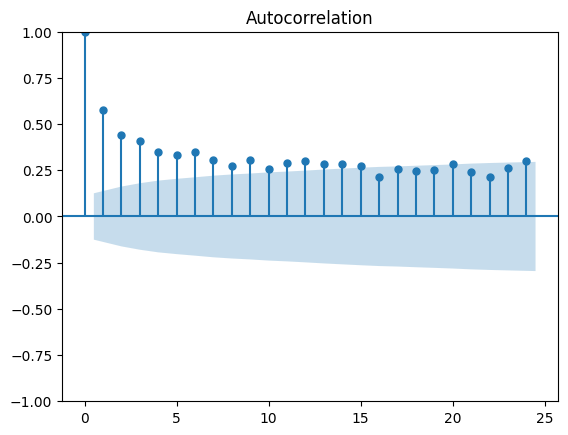

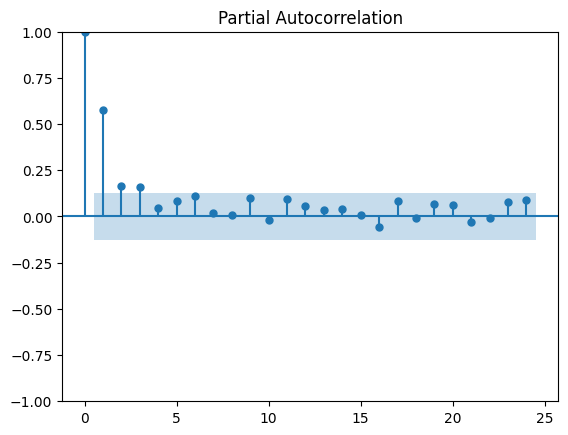

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA Forecast: 2017-09-11    11086.202849
2017-09-18    14509.294917
2017-09-25    15875.263934
2017-10-02    16420.347535
Freq: W-MON, Name: predicted_mean, dtype: float64
Test RMSE: 3348.4616022982414


In [ ]:
# Example1 ARIMA modeling of store no:1 and product family: 'GROCERY I'
arima_modeling(1, 'GROCERY I')

ADF Statistic: -8.611165016726979
p-value: 6.470050577877898e-14


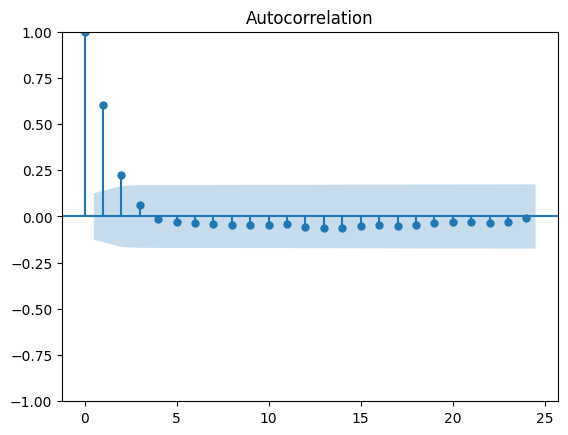

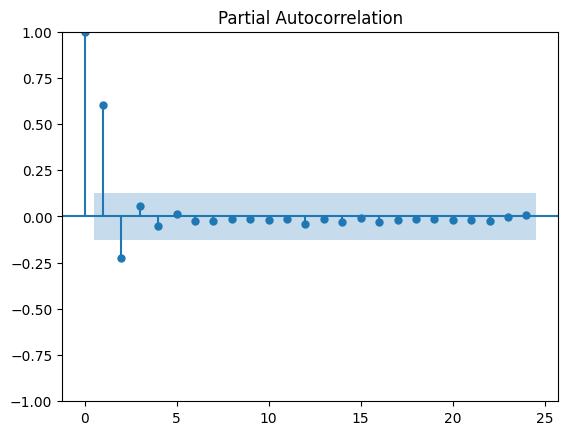

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA Forecast: 2017-09-11     498.973119
2017-09-18     756.094502
2017-09-25     913.512687
2017-10-02    1009.889288
Freq: W-MON, Name: predicted_mean, dtype: float64
Test RMSE: 1556.155681857036


In [ ]:
# Example2 ARIMA modeling of store no:2 and product family: 'FROZEN FOODS'
arima_modeling(2, 'FROZEN FOODS')